<a href="https://colab.research.google.com/github/kalhara-peiris/Customer_churn/blob/main/Untitled72.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import classification_report,accuracy_score,f1_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier,StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


In [31]:
df=pd.read_csv("customer_churn.csv")

dropping customerID as its an unique field

In [32]:
df=df.drop("customerID",axis=1)

# **EDA**

In [24]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges  Churn  
0           Electronic check          29.85         29.85     No  
1               Mailed check          56.95       1889.50     No  
2               Mailed check          53.85        108.15    Yes  
3  Bank transfer (automatic)          42.30       1840.75     No  
4           Electronic check          70.70        151.65    Yes  

[5 rows x 21 columns]

In [34]:
df["Churn"].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

We can see theres a class imbalance which we need to address

In [26]:
df.describe()

SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7043.000000  7043.000000     7043.000000   7032.000000
mean        0.162147    32.371149       64.761692   2283.300441
std         0.368612    24.559481       30.090047   2266.771362
min         0.000000     0.000000       18.250000     18.800000
25%         0.000000     9.000000       35.500000    401.450000
50%         0.000000    29.000000       70.350000   1397.475000
75%         0.000000    55.000000       89.850000   3794.737500
max         1.000000    72.000000      118.750000   8684.800000

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [28]:
print(df.duplicated().sum())


0


No duplicates

In [29]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [ ]:
null_rows=df[df["TotalCharges"].isnull()]
print(null_rows)

<bound method NDFrame.head of       gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
488   Female              0     Yes        Yes       0           No   
753     Male              0      No        Yes       0          Yes   
936   Female              0     Yes        Yes       0          Yes   
1082    Male              0     Yes        Yes       0          Yes   
1340  Female              0     Yes        Yes       0           No   
3331    Male              0     Yes        Yes       0          Yes   
3826    Male              0     Yes        Yes       0          Yes   
4380  Female              0     Yes        Yes       0          Yes   
5218    Male              0     Yes        Yes       0          Yes   
6670  Female              0     Yes        Yes       0          Yes   
6754    Male              0      No        Yes       0          Yes   

         MultipleLines InternetService       OnlineSecurity  \
488   No phone service             DSL                

Rows where total charges are null tenure also 0. so we can delete those rows while pre processing

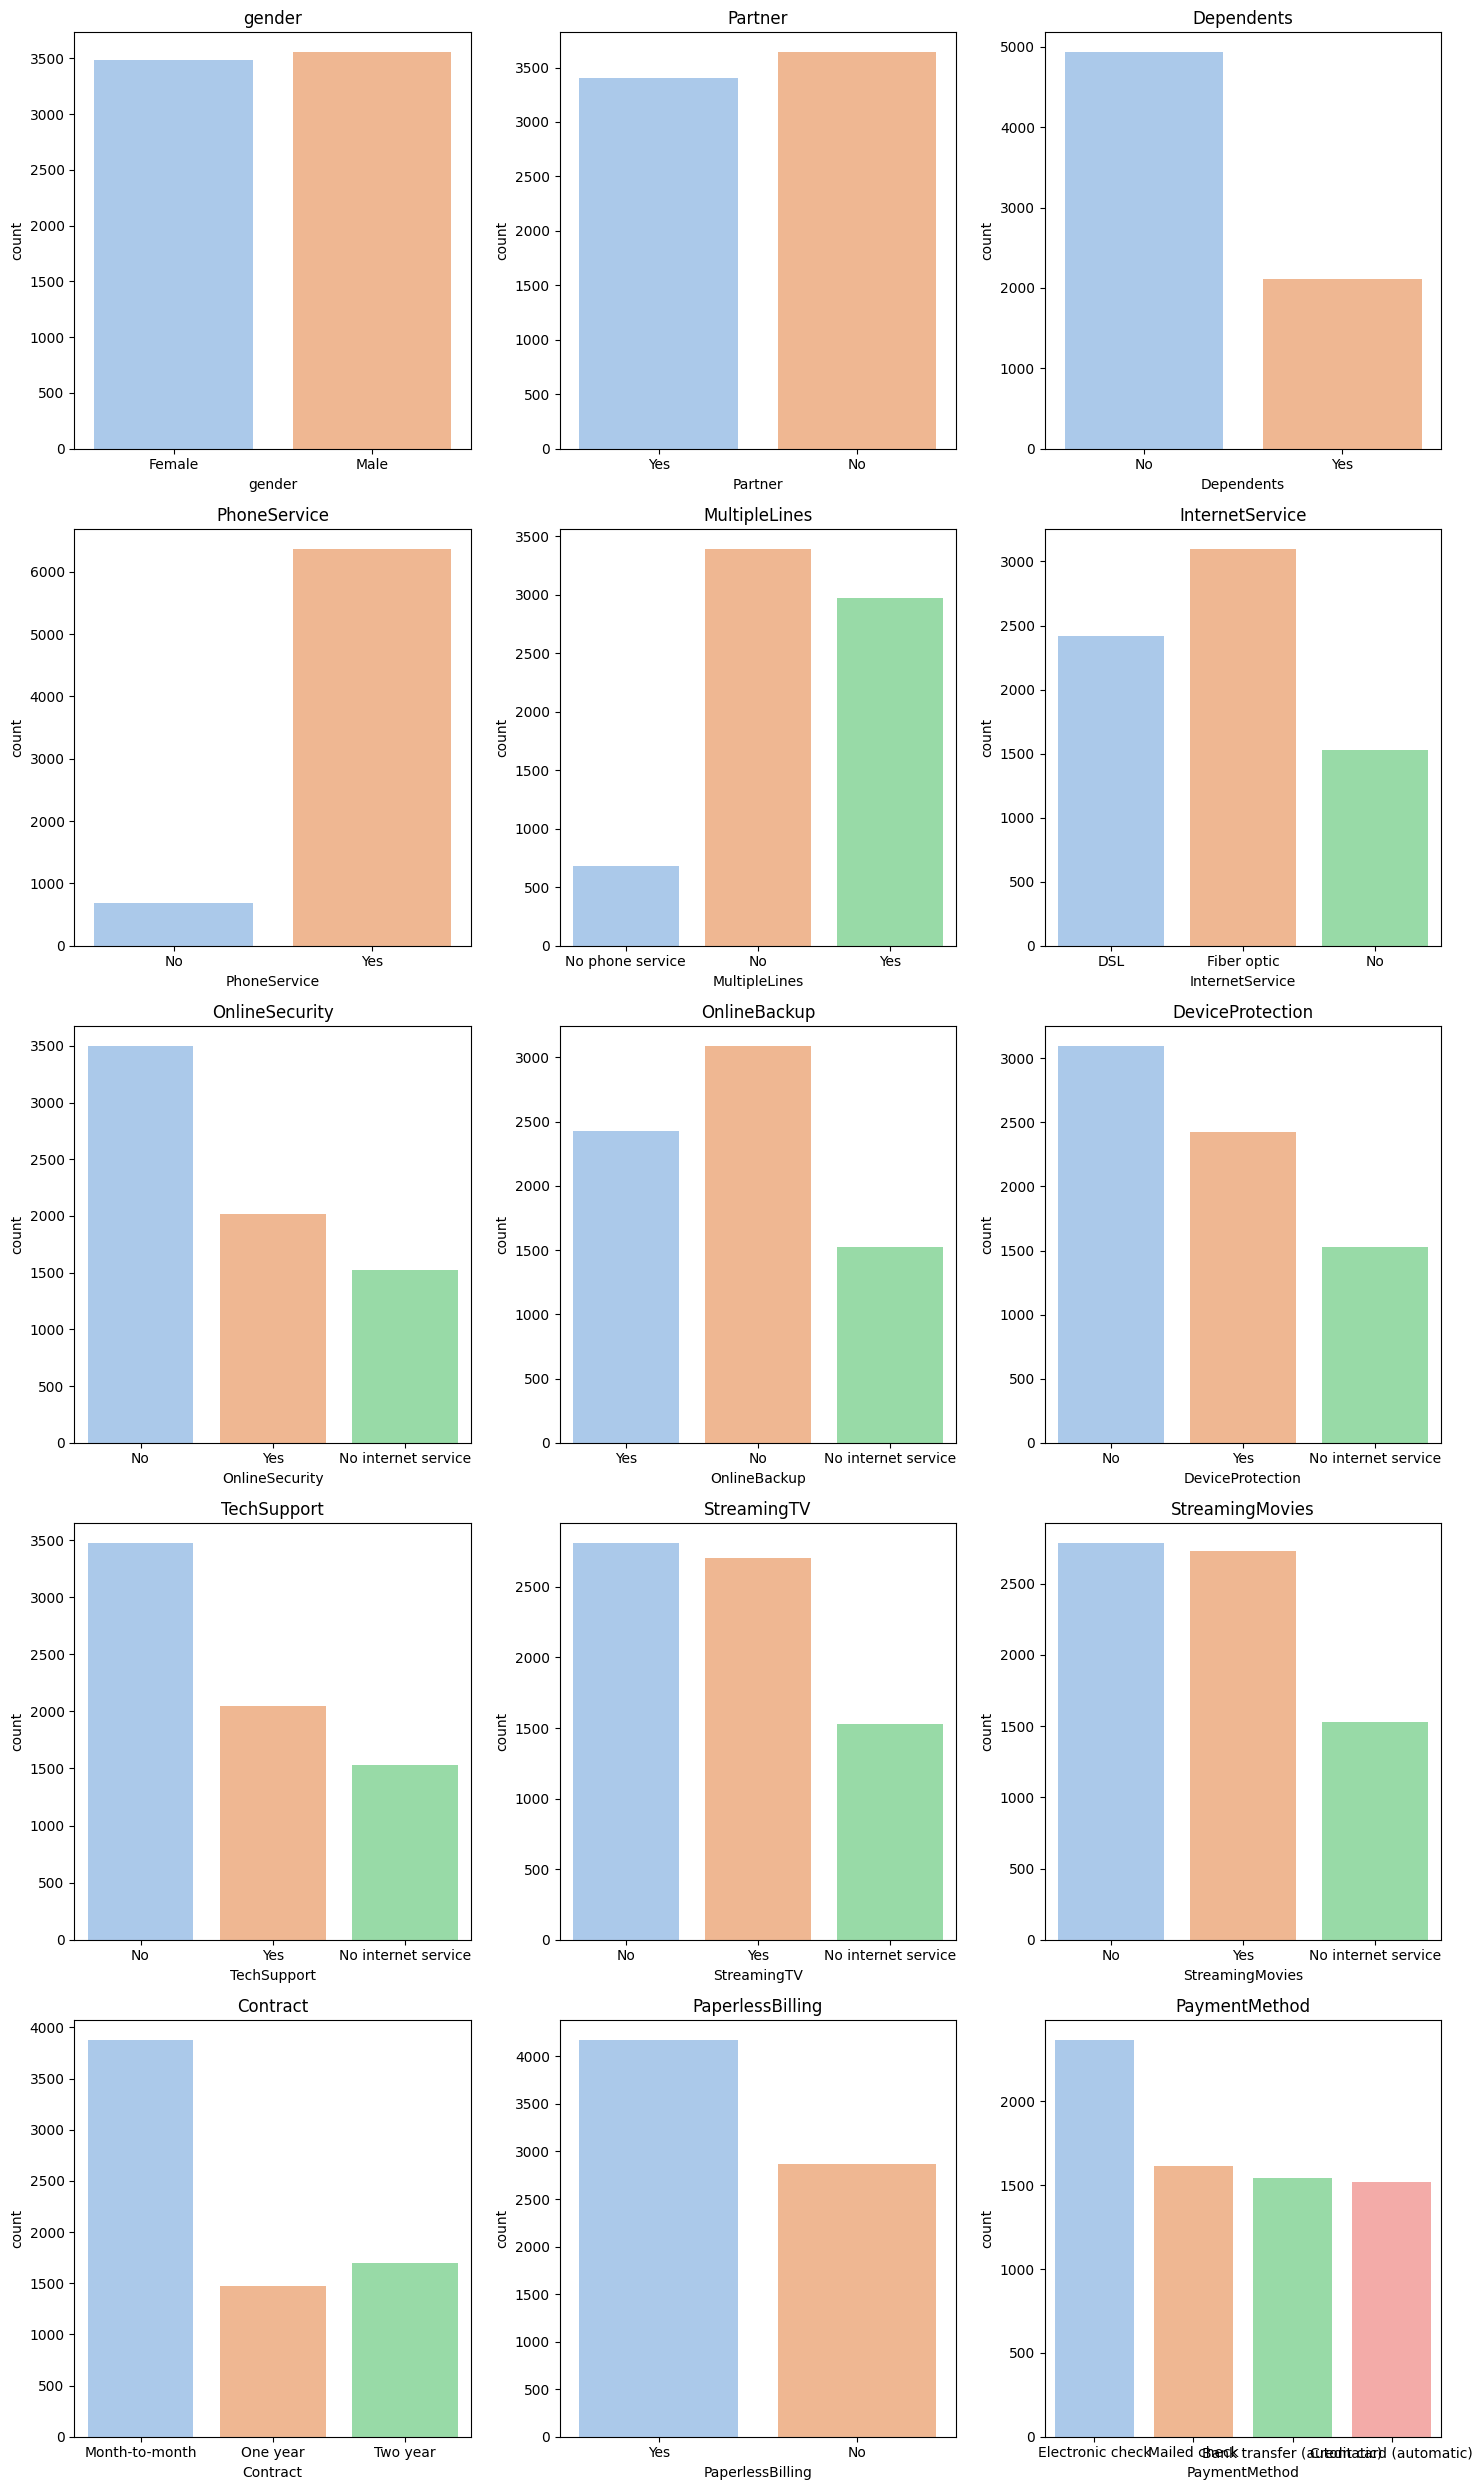

In [37]:
cols=list(df.select_dtypes(include=["object","category"]).columns)
cols.remove("Churn")
num=len(cols)
fig, axes=plt.subplots(5,3,figsize=(5*3,5*5))
axes = axes.flatten()  
for ax, col in zip(axes, cols):
    sns.countplot(x=col, data=df, hue=col, palette="pastel", dodge=False, ax=ax, legend=False)
    ax.set_title(col)

plt.tight_layout()
plt.show()

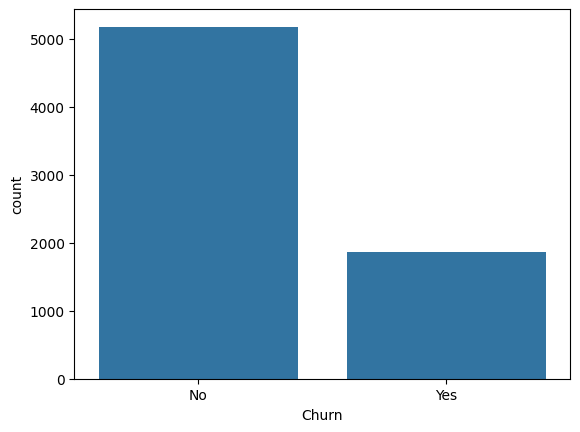

In [56]:
sns.countplot(x="Churn",data=df)
plt.show()

<Axes: >

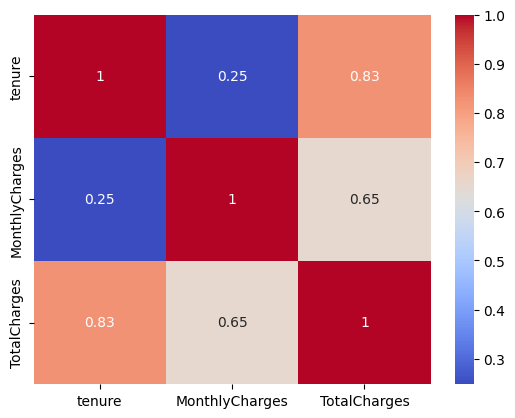

In [63]:
numerical_columns=["tenure","MonthlyCharges","TotalCharges"]
numerical_df=df[numerical_columns]
numerical_df=numerical_df.corr()
sns.heatmap(numerical_df,cmap="coolwarm",annot=True)

tenure and total charges have higher correlation. will use PCA for those 2

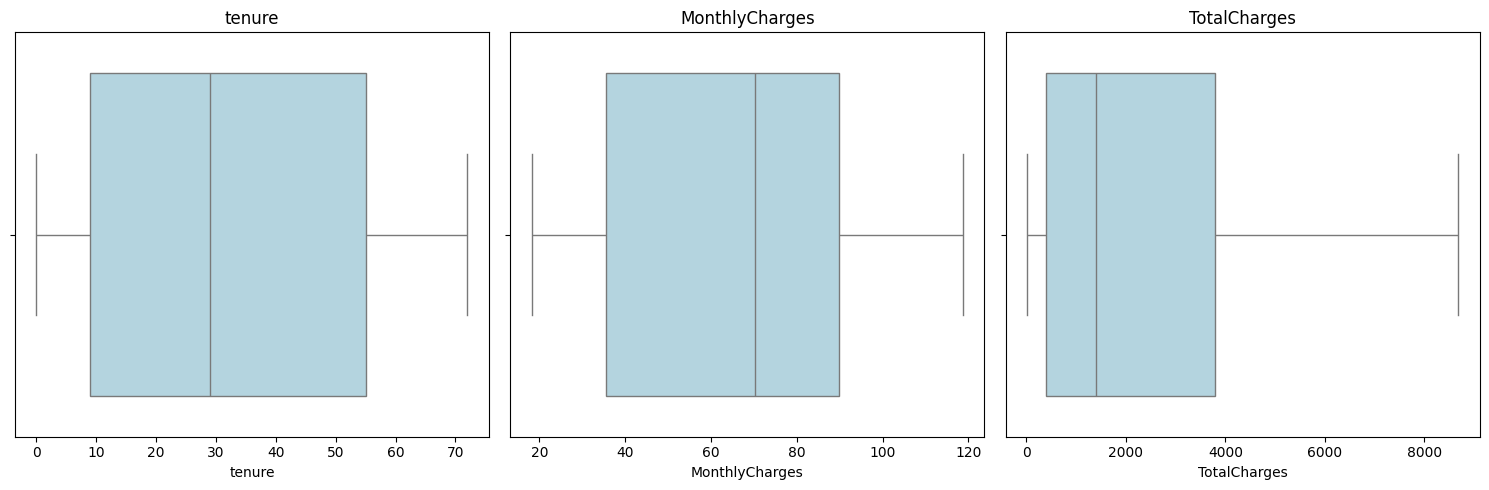

In [73]:
fig,axes=plt.subplots(1,3,figsize=(15,5))
for i,col in enumerate(numerical_columns):
    sns.boxplot(x=df[col],color="lightblue",ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

No outliers in numerical features

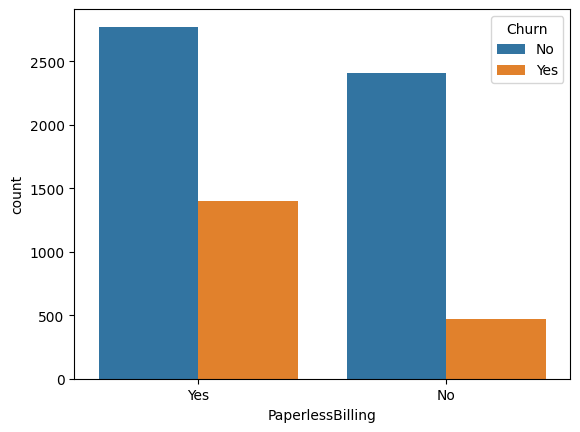

In [4]:
sns.countplot(x="PaperlessBilling",hue="Churn",data=df)
plt.show()


In [10]:
from scipy.stats import chi2_contingency
table=pd.crosstab(df["gender"],df["Churn"])
chi2,p,dof,expected=chi2_contingency(table)

print(f"p-value: {p}")

p-value: 0.48657873605618596


# **Pre Processing**

In [39]:
df.dropna(inplace=True)

droppping null rows as tenure is 0 in total charges null rows

In [40]:
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [41]:
cols=list(df.select_dtypes(include=["object","category"]).columns)
cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [42]:
one_hot_encoding=["Contract","MultipleLines","InternetService","PaymentMethod","StreamingMovies","StreamingTV","TechSupport","DeviceProtection","OnlineBackup","OnlineSecurity"]
for i in one_hot_encoding:
  cols.remove(i)
for i in cols:
  df[i]=LabelEncoder().fit_transform(df[i])
  

In [43]:
one_hot_encoding.remove("Contract")
df=pd.get_dummies(df,columns=one_hot_encoding)

In [44]:
encoder=OrdinalEncoder(categories=[["Month-to-month","One year","Two year"]])
df["Contract"]=encoder.fit_transform(df[["Contract"]])

In [45]:
numerical_columns=["tenure","MonthlyCharges","TotalCharges"]
scaler=StandardScaler()
df[numerical_columns]=scaler.fit_transform(df[numerical_columns])

Appplying PCA for highly correlated features

In [46]:
high_corr=["TotalCharges","tenure"]
from sklearn.decomposition import PCA 
pca=PCA(n_components=1)
df["charges_pca"]=pca.fit_transform(df[high_corr])
print(pca.explained_variance_ratio_)
df.drop(columns=high_corr, inplace=True)


[0.91294023]


In [123]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'Contract', 'PaperlessBilling', 'MonthlyCharges', 'Churn',
       'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'Onlin

# **Modelling**


In [15]:
for i in cols:
  print(df[i].value_counts())
  print("\n")

gender
Male      3555
Female    3488
Name: count, dtype: int64


Partner
No     3641
Yes    3402
Name: count, dtype: int64


Dependents
No     4933
Yes    2110
Name: count, dtype: int64


PhoneService
Yes    6361
No      682
Name: count, dtype: int64


PaperlessBilling
Yes    4171
No     2872
Name: count, dtype: int64


Churn
No     5174
Yes    1869
Name: count, dtype: int64




In [12]:
X=df.drop("Churn",axis=1)
y=df["Churn"]

In [13]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [134]:
X_train.head()

gender  SeniorCitizen  Partner  Dependents  Contract  PaperlessBilling  \
2142       0              0        0           1       1.0                 0   
1623       0              0        0           0       2.0                 1   
6074       1              0        1           0       0.0                 1   
1362       1              0        0           0       0.0                 1   
6754       1              0        0           1       2.0                 1   

      MonthlyCharges  MultipleLines_No  MultipleLines_Yes  \
2142        0.002935              True              False   
1623        1.078118             False               True   
6074       -1.373033             False              False   
1362        0.180747              True              False   
6754       -0.095111             False               True   

      InternetService_Fiber optic  PaymentMethod_Bank transfer (automatic)  \
2142                        False                                    False   
1623                         True                                     True   
6074                        False                                    False   
1362                         True                                    False   
6754                        False                                     True   

      PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
2142                                  False                           False   
1623                                  False                           False   
6074                                  False                            True   
1362                                  False                            True   
6754                                  False                           False   

      TechSupport_No  DeviceProtection_No  OnlineBackup_No  OnlineSecurity_No  \
2142            True                False             True              False   
1623            True                 True            False               True   
6074            True                 True             True               True   
1362            True                 True             True               True   
6754           False                 True            False              False   

      OnlineSecurity_Yes  charges_pca  
2142                True    -0.622709  
1623               False     1.510551  
6074               False    -1.608381  
1362               False    -1.455074  
6754                True    -0.932525

SMOTETomek is a resampling technique that balances imbalanced datasets by combining SMOTE, which adds synthetic minority class samples, and Tomek Links, which remove overlapping majority class samples. This improves class balance and helps models learn more effectively.

In [120]:
from imblearn.combine import SMOTETomek
X_train, y_train = SMOTETomek().fit_resample(X_train, y_train)


# **Model Training**

In [15]:
model=RandomForestClassifier(random_state=42)


In [22]:
param_grid={
    'n_estimators': [100],
    'max_depth': [20],
    "class_weight":[None,"balanced","balanced_subsample"],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    "max_leaf_nodes":[30],
    'max_features': ["log2", 'sqrt']
}

grid_search=GridSearchCV(model,param_grid,cv=5,scoring="f1",n_jobs=-1,verbose=2)
grid_search.fit(X_train,y_train)
print("Best parameters", grid_search.best_params_)
y_pred=grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test,y_pred))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters {'class_weight': 'balanced_subsample', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1033
           1       0.52      0.74      0.61       374

    accuracy                           0.75      1407
   macro avg       0.71      0.75      0.71      1407
weighted avg       0.79      0.75      0.76      1407



To get desired resuts like a higher recall we can adjst the threshold

In [92]:
from sklearn.metrics import classification_report
import numpy as np

# Get predicted probabilities for the positive class
y_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Try different thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    print(f"\nThreshold: {thresh}")
    print(classification_report(y_test, y_pred_thresh, digits=3))



Threshold: 0.3
              precision    recall  f1-score   support

           0      0.953     0.508     0.663      1033
           1      0.407     0.930     0.566       374

    accuracy                          0.620      1407
   macro avg      0.680     0.719     0.614      1407
weighted avg      0.808     0.620     0.637      1407


Threshold: 0.4
              precision    recall  f1-score   support

           0      0.928     0.621     0.744      1033
           1      0.453     0.866     0.595       374

    accuracy                          0.687      1407
   macro avg      0.690     0.744     0.670      1407
weighted avg      0.802     0.687     0.705      1407


Threshold: 0.5
              precision    recall  f1-score   support

           0      0.904     0.708     0.794      1033
           1      0.495     0.791     0.609       374

    accuracy                          0.730      1407
   macro avg      0.699     0.750     0.701      1407
weighted avg      0.795   

In [27]:
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5,7,9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

xgb=XGBClassifier(use_label_encoder=False,)
random_search= RandomizedSearchCV(
    xgb,param_distributions=params,
    n_iter=50,scoring="f1",cv=5,verbose=1,n_jobs=-1
)
random_search.fit(X_train,y_train)
best_model=random_search.best_estimator_
print(random_search.best_params_)
tune_pred=best_model.predict(X_test)
print(classification_report(y_test,tune_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.7}
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1033
           1       0.55      0.65      0.59       374

    accuracy                           0.76      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.76      0.77      1407



c:\Users\kalha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:04:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [47]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

# Evaluate
print("Test set accuracy:", accuracy_score(y_test, y_pred))

Test set accuracy: 0.7683013503909026


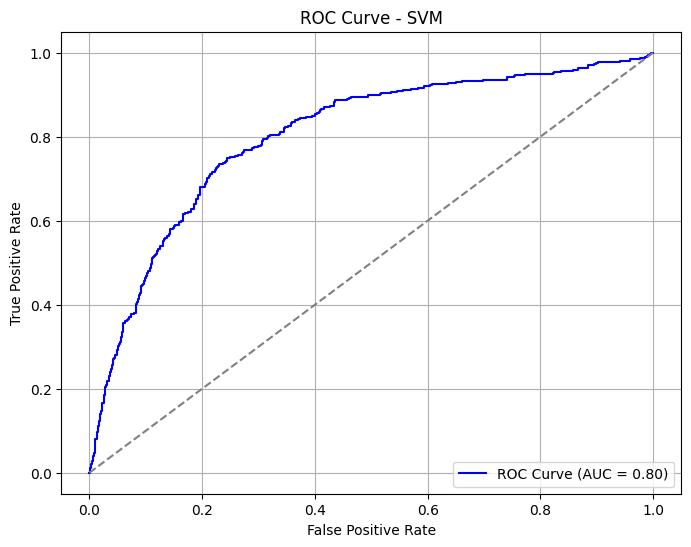

In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Fit the model
svm = SVC(probability=False)  
svm.fit(X_train, y_train)

y_scores = svm.decision_function(X_test)  # Get scores for ROC

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


###  ROC Curve - Support Vector Machine (SVM)

The ROC curve above illustrates the performance of the SVM classifier on the test dataset. The **True Positive Rate (TPR)** is plotted against the **False Positive Rate (FPR)** at various threshold settings.

- **AUC (Area Under the Curve): 0.80**  
  This indicates that the model has good discriminatory power — it correctly distinguishes between the classes 80% of the time.
- A curve closer to the top-left corner suggests better performance. The diagonal gray line represents a random classifier (AUC = 0.5).
- This model shows a significant improvement over random guessing.

 Overall, the SVM model performs reliably and can be considered effective for this classification task.


In [48]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.80      0.84      1033
           1       0.55      0.67      0.61       374

    accuracy                           0.77      1407
   macro avg       0.71      0.74      0.72      1407
weighted avg       0.79      0.77      0.77      1407



As theres a class imbalance i compared with f1 score rather than accuracy. we can see svc and random forest have a god f1 score than XGB and svc have a higher accuracy than random forest

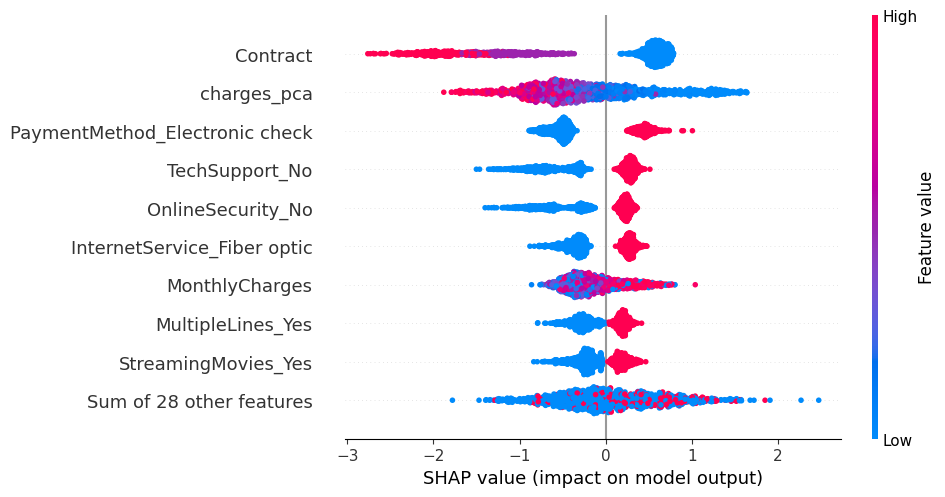

In [29]:
import shap
explainer=shap.Explainer(best_model)
shap_values=explainer(X_test)
shap.plots.beeswarm(shap_values)

The plot above visualizes the SHAP (SHapley Additive exPlanations) values, showing how each feature contributes to the model's prediction for customer churn.

X-axis (SHAP value): The impact of a feature on the model's output. Values > 0 push the prediction toward churn; values < 0 push it toward no churn.

Color: Represents the actual feature value (blue = low, red = high).

Each dot: One customer instance. Its position shows the SHAP value, and its color shows the feature value.

Key Insights:
Contract type has a strong influence. Long-term contracts (blue dots) reduce churn risk.

Higher charges_pca values (red) push predictions toward churn.

Electronic check payment and lack of Tech Support or Online Security are associated with higher churn.

Fiber optic internet and higher Monthly Charges tend to increase churn risk.

The influence of Streaming and Multiple Lines is smaller but still notable.

This plot helps interpret the model by revealing which features drive churn and how they interact at a granular level.